## 3.5 階層ベイズモデル

In [8]:
import pandas as pd
%matplotlib inline

import os

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns

sns.set()

### 3.5.1 モデル概要

$$
\begin{align}
    &y_{i, n} = a_i x_{i, n} + b_i + \varepsilon_n \\
    &\varepsilon_{i, n} \sim \mathcal{N}(0, \sigma_y^2)
\end{align}
$$


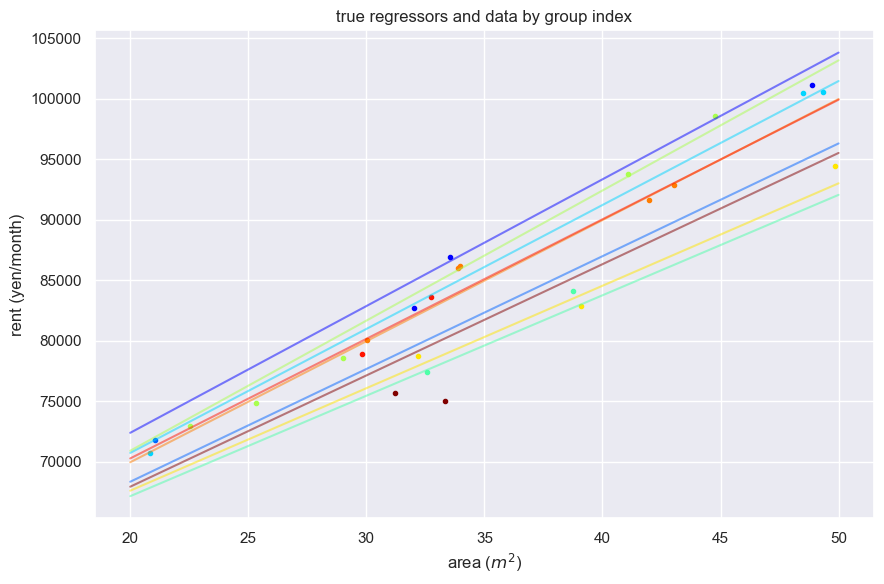

In [21]:
# データ読み込み
this_file_path = os.path.abspath(".")
data_path = os.path.join(this_file_path, "../../data")
df_data = pd.read_csv(os.path.join(data_path, "toy_data.csv"))

# 真の係数パラメータの読み込み
df_coef = pd.read_csv(os.path.join(data_path, "true_coef.csv"))

# 説明変数
x_data = df_data["x"].values

# 目的変数
y_data = df_data["y"].values

# 地域グループ
group_idx = df_data["systemID"].values.astype(int)

# 地域ごとの傾きとバイアス
a_vector, b_vector = df_coef["a"].values, df_coef["b"].values

# 可視化用
x_linspace = np.linspace(20, 50, 100)

fig, ax = plt.subplots(figsize=(9, 6))
cm10 = plt.get_cmap("jet", 10)
for i in range(9):
    # 真の関数の可視化
    ax.plot(x_linspace, a_vector[i] * x_linspace + b_vector[i], color=cm10(i+1), alpha=0.5)
    # 学習データ可視化
    ax.scatter(x_data[group_idx == i], y_data[group_idx == i], marker=".", color=cm10(i+1))

ax.set_xlabel("area ($m^2$)")
ax.set_ylabel("rent (yen/month)")
ax.set_title("true regressors and data by group index")
plt.tight_layout()
plt.show()

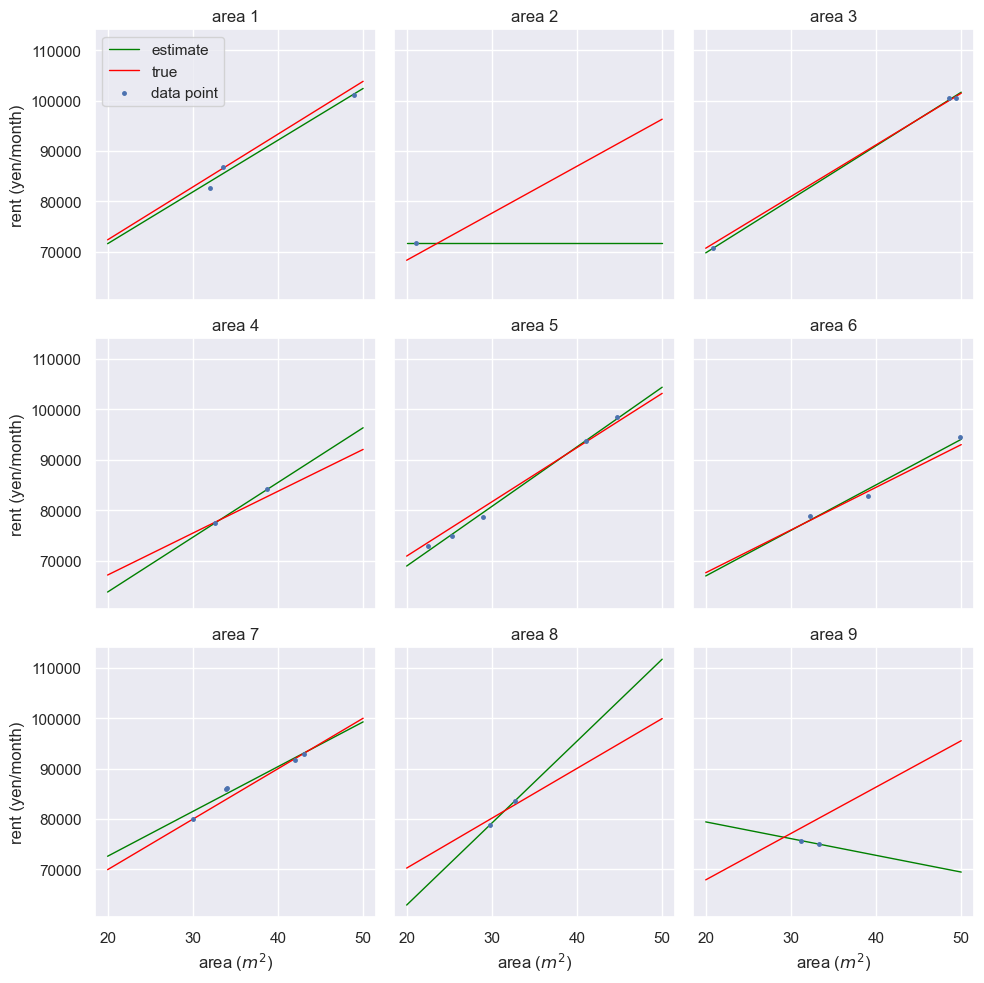

In [45]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, sharex=True, sharey=True)
x_new = np.linspace(20, 50, 100)

# 地域ごとに処理
for i in range(9):
    row_index = i // 3
    col_index = i % 3

    # 地域グループ取り出し
    x_i = x_data[group_idx == i]
    y_i = y_data[group_idx == i]

    # 線形回帰
    lr = LinearRegression()
    lr.fit(x_i.reshape(-1, 1), y_i.reshape(-1, 1))

    # 線形回帰可視化
    y_linear_model = lr.predict(x_new.reshape(-1, 1))
    ax[row_index, col_index].plot(x_new, y_linear_model, color="green", linewidth=1, label="estimate")

    # 真の関数可視化
    y_true = a_vector[i] * x_new + b_vector[i]
    ax[row_index, col_index].plot(x_new, y_true, color="red", linewidth=1, label="true")

    # 学習データ可視化
    ax[row_index, col_index].scatter(x_i, y_i, marker=".", s=25, zorder=2, label="data point")

    ax[row_index, col_index].set_title("area {}".format(i + 1))
    if row_index == 2:
        ax[row_index, col_index].set_xlabel("area ($m^2$)")
    if col_index == 0:
        ax[row_index, col_index].set_ylabel("rent (yen/month)")

ax[0, 0].legend()
plt.tight_layout()
plt.show()

上記より, 単純な回帰の場合にはデータが不足していることに起因して真の回帰から外れてしまう.

### 3.5.2 実装

$$
\begin{align*}
    &y_n = a_i x_n + b_i + \varepsilon_n \\
    &a_i \sim \mathcal{N}(\mu_a, \sigma_a^2) \\
    &b_i \sim \mathcal{N}(\mu_b, \sigma_b^2) \\
    &\mu_a \sim \mathcal{N}(\mu_{ha}, \sigma_{ha}^2) \\
    &\sigma_a \sim \text{HalfCauchy}(\beta_a) \\
    &\mu_b \sim \mathcal{N}(\mu_{hb}, \sigma_{hb}^2) \\
    &\sigma_b \sim \text{HalfCauchy}(\beta_b) \\
    &\varepsilon_n \sim \mathcal{N}(0, \sigma_y^2)
\end{align*}
$$

In [50]:
group_num = 9
with pm.Model() as model:
    # 説明変数
    X_shared = pm.Data("x", x_data)

    # 傾きについてのハイパーパラメータの事前分布
    a_mu = pm.Normal("a_mu", mu=50.0, sigma=10.0)
    a_sigma = pm.HalfCauchy("a_sigma", beta=100.0)

    # 地域ごとの傾き
    a_offset = pm.Normal("a_offset", mu=a_mu, sigma=a_sigma, shape=group_num)

    # バイアスについてのハイパーパラメータの事前分布
    b_mu = pm.Normal("b_mu", mu=50000.0, sigma=1000.0)
    b_sigma = pm.HalfCauchy("b_sigma", beta=1000.0)

    # 地域ごとのバイアス
    b_offset = pm.Normal("b_offset", mu=b_mu, sigma=b_sigma, shape=group_num)

    # 尤度関数
    y = pm.Normal("y", mu=a_offset[group_idx] * X_shared + b_offset[group_idx], sigma=1000, observed=y_data)

In [51]:
with model:
    # MCMC による推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [b_offset, b_sigma, b_mu, a_offset, a_sigma, a_mu]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 23 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'a_mu'}>,
        <AxesSubplot:title={'center':'a_mu'}>],
       [<AxesSubplot:title={'center':'a_sigma'}>,
        <AxesSubplot:title={'center':'a_sigma'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'b_mu'}>,
        <AxesSubplot:title={'center':'b_mu'}>],
       [<AxesSubplot:title={'center':'b_sigma'}>,
        <AxesSubplot:title={'center':'b_sigma'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>]], dtype=object)

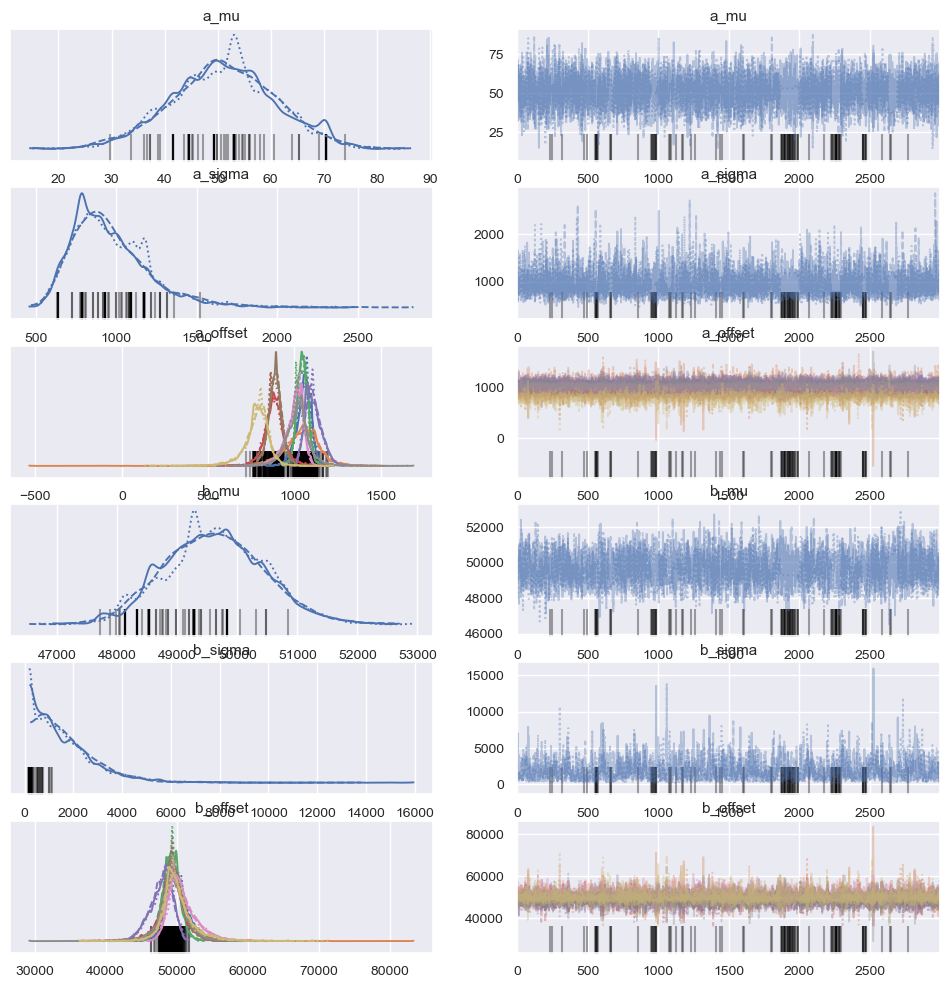

In [52]:
az.plot_trace(trace, var_names=["a_mu", "a_sigma", "a_offset", "b_mu", "b_sigma", "b_offset"])

In [53]:
for var_info in az.rhat(trace).values():
    print(var_info.name, var_info.values.round(3), sep=" ")

a_mu 1.002
a_offset [1.001 1.    1.001 1.    1.003 1.002 1.001 1.002 1.   ]
b_mu 1.0
b_offset [1.001 1.    1.001 1.001 1.002 1.    1.001 1.001 1.   ]
a_sigma 1.001
b_sigma 1.008


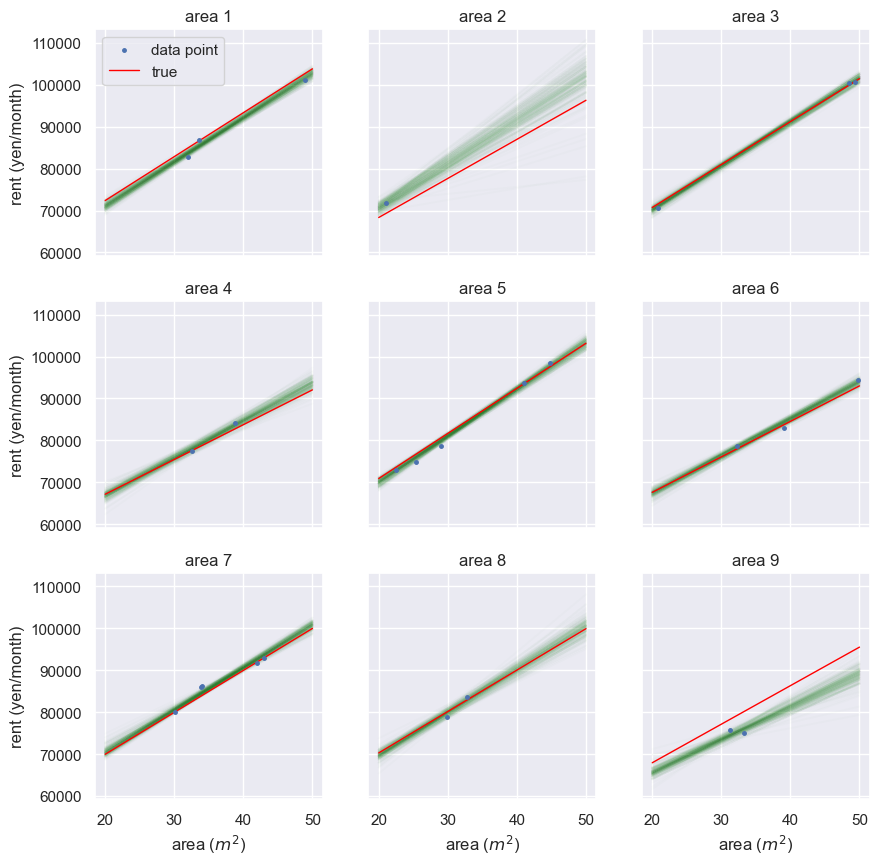

In [65]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, sharex=True, sharey=True)
x_new = np.linspace(20, 50, 100)

# 地域ごとに処理
for i in range(9):
    row_index = i // 3
    col_index = i % 3

    # 地域ごとの係数パラメータの MCMC サンプル平均値と標準偏差を算出
    # chain = 1 のみ使用している ?
    a_i_mcmc_samples = trace.posterior["a_offset"][0, :, i]
    b_i_mcmc_samples = trace.posterior["b_offset"][0, :, i]

    # 学習データ可視化
    x_i = x_data[group_idx == i]
    y_i = y_data[group_idx == i]
    ax[row_index, col_index].scatter(x_i, y_i, marker=".", s=25, zorder=3, label="data point")

    # MCMC サンプルを使って予測分布の平均を可視化
    for k in range(0, 3000, 15):
        y_new_samples = a_i_mcmc_samples[k].values * x_new + b_i_mcmc_samples[k].values
        ax[row_index, col_index].plot(x_new, y_new_samples, alpha=0.01, color="green", zorder=1)

    # 真の関数可視化
    y_true = a_vector[i] * x_new + b_vector[i]
    ax[row_index, col_index].plot(x_new, y_true, color="red", linewidth=1, label="true")

    ax[row_index, col_index].set_title("area {}".format(i + 1))
    if row_index == 2:
        ax[row_index, col_index].set_xlabel("area ($m^2$)")
    if col_index == 0:
        ax[row_index, col_index].set_ylabel("rent (yen/month)")

ax[0, 0].legend()
plt.show()